<h1><center>Amazon Beauty Products - Recommender System</center></h1>
<h2><center>Milestone Report</center></h2>

## 1. Introduction

### 1.1 Problem

These days, recommendation engines or recommender systems are commonly used in the digital domain, especially on e-commerce sites. According to Wikipedia, a recommender system or a recommendation system is a subclass of information filtering system that seeks to predict the "rating" or "preference" a user would give to an item. The main goal here is to provide relevant suggestions to online users to make better decisions about their purchases. 

Amazon uses a recommendation system for suggesting products that it's customers might like. According to McKinsey, 35% of Amazon.com's revenue is generated by it's recommendation engine. 

In this project, I plan to build an intelligent recommendation engine for beauty products that are sold on Amazon.com. By providing recommendations, Amazon.com will give its customers the ability to take their brand experiences into their hands and make informed decisions. This level of personalization will support higher customer retention and reinforce brand loyalty.

### 1.2 Approach

#### Data Wrangling:

After loading the json files into pandas dataframe, the raw data will be cleaned, structured and enriched into a cleaner format. Clean data will allow quicker and better analysis, producing more accurate results. The identification and removal of error and duplicity in datasets will create a reliable dataset, enabling an outcome of better quality.

#### EDA:

EDA (Exploratory Data Analysis) is the initial basic exploration of the dataset in a systematic manner using visual methods. This step will include identification and elimination of outliers as well as checking for correlations between the independent variables.

#### Machine Learning:

### 1.3 Impact

Amazon is a widely popular e-commerce company with a huge selection of apparel, household items, beauty products, books etc. Customers do online shopping from it’s website and frequently, provide reviews of these products based on their experience. In this project, I will focus mainly on the beauty product. So my client is the product owner of the Amazon beauty department. Through this recommendation system, they will be able to suggest beauty products to their customers, based on the likes and dislikes of other customers. Strong recommender systems can have positive effects on user experience. This can result into higher customer satisfaction and retention, and in turn boost revenues.

### 1.4 Dataset

The data sets for this project are publicly provided by Julian McAuley of UCSD. They are available in json format on the website http://jmcauley.ucsd.edu/data/amazon/links.html. They contain reviews spanning May 1996 – Jul 2014.

The Product reviews dataset has the following columns:
ReviewerId, ProductId, ReviewText, OverallRating, Summary, ReviewTimestamp

The Product metadata dataset has these columns:
ProductId, Description, Category, Brand, ImageURL, SalesRank, SalesPrice

## 2. Data Collection

The dataset has been downloaded from the website: http://jmcauley.ucsd.edu/data/amazon/links.html
(Citation:
Ups and downs: Modeling the visual evolution of fashion trends with one-class collaborative filtering
R. He, J. McAuley
WWW, 2016)

There are 2 individual json files containing the beauty product reviews and metadata from Amazon. The reviews file has ~2 million reviews spanning May 1996 - July 2014. The metadata file contains the details of ~260K beauty products sold at Amazon.

Reviews includes product ratings, text of the review and helpfulness votes.  


| Column        | Description                     |
|---------------|---------------------------------|
|reviewerID     | Reviewer ID                     |
|asin           | Product ID                      |
|reviewerName   | Name of reviewer                |
|helpful        | Helpfulness rating of the review|
|reviewText     | Text of the review              |
|overall        | Rating of the product           |
|summary        | Summary of the review           |
|unixReviewTime | Unix time of the review         | 
|reviewTime     | Raw time of the review          |   

Metadata includes descriptions, category information, price, sales-rank, brand info and image features.  
  

| Column     | Description                           |
|------------|---------------------------------------|
|asin        | Product ID                            |
|description | Product description                   |
|title       | Name of the product                   |
|imUrl       | URL of the product image              |
|salesRank   | Sales rank information                |
|categories  | List of categories product belongs to |
|price       | Price in US Dollars                   | 
|related     | Related products                      |
|brand       | Brand name                            | 

The json files were retrieved in compressed format. They were parsed line by line and loaded into pandas dataframes reviews and meta. Then these dataframes were written to .csv files for analysis and modeling.

Load the raw json compressed files into pandas dataframes.

In [1]:
import pandas as pd
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')   

In [3]:
meta = getDF('meta_Beauty.json.gz')

reviews = getDF('reviews_Beauty.json.gz')

In [4]:
meta.to_csv('meta_beauty.csv')

reviews.to_csv('reviews_beauty.csv')

## 2. Data Wrangling

### 2.1 Metadata file

The metadata file contains the details of ~260K beauty products sold at Amazon. There are 9 columns in the file including asin, description, title, brand, categories, related, price, sales rank and image url. No duplicate values were found in the asin column. 

51% of the items were missing "brand" information. Since this is a large percentage, the column could not be dropped. 444 items were missing the "title" information. So "brand" and "title" columns were merged into a single column and the individual columns were then dropped. 

The image url column does not seem to have much meaning, so it was also dropped from the dataframe.

The "salesRank" column had values in dict format (key-value pairs). So this column was split into multiple columns where each key became the column name and the value became the column value. Some of these new columns were not related to Beauty and Personal care so they were dropped. Only the new columns "Beauty" and "Health & Personal Care" were retained.

At this point, the resulting dataframe was written to a .csv file (cleaned_meta.csv).

It includes the columns:
asin, description, categories, price, related, brand_title, Health & Personal Care, Beauty

Next came the most challenging column for cleaning. 

This is the "related" column which had data in the following format:

{'also_bought': ['B002J2KOXK', 'B008TCVZ6Y'], 'also_viewed': ['B002J2KOXK'], 'bought_together': ['B002J2KOXK'], 'buy_after_viewing': ['B002J2KOXK']}

It made most sense to count the number of times an asin occurred in any of these 4 key-value pairs and use that count as an identification of popular and unpopular item. This required creation of a new column called "related_count".

The "asin" and "related" columns were first copied to a separate dataframe. The "related" column was then split into 4 new columns "also_bought", "also_viewed", "bought_together" and "buy_after_viewing". Then the values in these 4 columns were concatenated into a large string. Using iterrows, each asin in the dataframe was checked against the string and the number of occurrences of this asin in the string was captured in the "related_count" column. This particular operation took 20 hours to complete and the resulting dataframe was immediately captured into a .csv file (cleaned_related.csv).

The code for data wrangling of metadata file can be found at:
https://github.com/venustrip/Amazon-Recommendation-Engine/blob/master/clean_meta.ipynb

### 2.2 Reviews File

The reviews file has ~2 million reviews collected between May-1996 and July-2014. There are 9 columns in the file including: reviewerID, reviewerName, asin, helpful, reviewText, overall, summary, unixReviewTime and reviewTime.

12248 rows were missing the "reviewerName" information. Also there were some "reviewerID" with multiple values under "reviewerName". Since we can build our model just with the ID, the "reviewerName" column was dropped from the dataframe.

The "summary" and "reviewText" columns have similar information. 14 rows were missing the "summary" information. The 2 columns were merged into "review" column and the individual columns were dropped.

The column "reviewTime" was in text format, so it was converted to datetime and the column "unixReviewTime" was dropped.

The "helpful" column had values in list format, where the first element indicated the number of upvotes and second element indicated the number of downvotes for the review. This column was split into two: "upvotes" and "downvotes" and the original "helpful" column was dropped.

Since the "review" column is most significant for this project and comprises of large text values, it can be used for natural language processing.

First the wordcount of each review was stored into a new column "word_count". 

Next, the text was converted to lowercase to avoid having multiple versions of one word.  

All punctuation marks were removed since they do not add any extra value while processing text data.

Finally, the stop words and 50 most rare words were removed.

Once these steps completed, sentiment analysis was performed on all the reviews and polarity was calculated. This value was stored for each review in the newly created "polarity" column.

After the cleaning, the following columns existed in the dataframe:
reviewerID, asin, overall, review, upvotes, downvotes, word_count, polarity

The dataframe was written to a .csv file for further analysis (cleaned_reviews.csv).

The code for data wrangling of reviews file can be found at: https://github.com/venustrip/Amazon-Recommendation-Engine/blob/master/clean_reviews.ipynb

### 2.3 Cleaned Datasets

All the cleaned datasets were written to .csv files. The first file has the metadata, the second one has the related_count information for the products and the third file has all the reviews for these products.

The "meta" file includes:
1. asin
2. description
3. categories
4. price
5. related
6. brand_title
7. health_and_personal_care
8. beauty

The "related" file includes:
1. asin
2. related_count

The "reviews" file includes:
1. reviewerID
2. asin
3. overall
4. review
5. upvotes
6. downvotes
7. word_count
8. polarity

## 3. Exploratory Data Analysis

In [5]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)

pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

import warnings 
warnings.filterwarnings('ignore')

Read the cleaned files into dataframes.

In [8]:
reviews = pd.read_csv('cleaned_reviews.csv').drop(['Unnamed: 0'],axis=1)
meta = pd.read_csv('cleaned_meta.csv',index_col=0)
related = pd.read_csv('cleaned_related.csv',index_col=0)

In [9]:
reviews.head(2)

,reviewerID,asin,overall,reviewTime,review,upvotes,downvotes,word_count,polarity
0,A39HTATAQ9V7YF,0205616461,5,2013-05-28,bioactive antiaging serum love moisturizer would recommend someone dry skin fine lines wrinkles using brand day night serum,0,0,34,0.283333
1,A3JM6GV9MNOF9X,0558925278,3,2012-12-14,product ok im use baby kabuki moment received product deadlinei tested baby kabuki quality material best packaging cute love itthe fibers smell soft,0,1,44,0.520000


In [10]:
meta.head(2)

,asin,description,categories,price,related,brand_title,Health & Personal Care,Beauty
0,0205616461,"As we age, our once youthful, healthy skin succumbs to an enzymatic imbalance that wears away the cellular network, resulting in skin thinning and aging. Combining the best of nature and cosmetic biotechnology, Bio-Active products are formulated with Enzymes that gently exfoliate the skin and stimulate regeneration for a youthful glow. Benefiting from fertile orchards in the Italian countryside, Bio-active formulas are rich in phytohormones, flavonoids and fatty acids from active extracts in Apple and Pear Seeds ,enzymatically modified and developed especially for the care of aging skin. This repairing fluid helps to nourish and firm by accelerating penetration and delivery of active principles to the skin, giving it a more youthful appearance. \n\nAdvanced ""Probiotic"" Complex from nourishing milk proteins regains the skin's natural equilibrium, boosts its immunities and protects it against environmental and biological stress.\n\nPeptides and Ceramides help to firm and regenerate the skin by stimulating collagen production and strengthening the epidermis.\n\nA Calming Botanical Complex of Hyaluronic Acid and Wheat Germ Extract hydrates and restores the skin's protective barriers.\n\nA nutritive Vitamin Complex moisturizes and protects the skin from damaging environmental factors. \n\nParacress Extract, a natural alternative to cosmetic injections, limits and relaxes micro-contractions that create facial lines, producing immediate and long-term smoothing of the skin.\n\nTo Use: Apply a few pumps to Apply a few pumps to a clean and dried face, neck and dcollet.","[['Beauty', 'Skin Care', 'Face', 'Creams & Moisturizers']]",NaN,"{'also_viewed': ['XYZ'], 'also_bought': ['XYZ'], 'bought_together': ['XYZ'], 'buy_after_viewing': ['XYZ']}",Bio-Active Anti-Aging Serum (Firming Ultra-Hydrating Serum),461765.0,NaN
1,0558925278,"Mineral Powder Brush--Apply powder or mineral foundation all over face in a circular, buffing motion and work inward towards nose.\n\nConcealer Brush--Use with liquid or mineral powder concealer for more coverage on blemishes and under eyes. \n\nEye Shading Brush-- Expertly cut to apply and blend powder eye shadows.\n\nBaby Kabuki-- Buff powder over areas that need more coverage. \n\nCosmetic Brush Bag-- 55% hemp linen, 45% cotton","[['Beauty', 'Tools & Accessories', 'Makeup Brushes & Tools', 'Brushes & Applicators']]",NaN,"{'also_viewed': ['XYZ'], 'also_bought': ['XYZ'], 'bought_together': ['XYZ'], 'buy_after_viewing': ['XYZ']}",Eco Friendly Ecotools Quality Natural Bamboo Cosmetic Mineral Brush Set Kit of 4 Soft Brushes and 1 Pouch Baby Kabuki Eye Shading Brush Mineral Powder Brush Concealer Brush(travle Size),NaN,402875.0


In [11]:
related.head(2)

,asin,related_count
0,0205616461,0.0
1,0558925278,0.0


Let's quickly check if the related_count for a random asin matches the number of times it appears in the related column of meta dataframe.

In [12]:
related['related_count'].min(), related['related_count'].max()

(0.0, 3937.0)

In [13]:
related[related['related_count']==3937]

,asin,related_count
141975,B005BF1M10,3937.0


In [14]:
meta.related.str.count('B005BF1M10').sum()

3937

The number looks good so we can drop the related column from meta dataframe. We have the exact count of all products stored in related_count column of related dataframe.

Next let's find the main and sub-category of each product. The unpacked list will be easier to use and analyze.

In [16]:
meta['main_cat'] = meta.categories.str.split(',').str[1].str.replace("'","")
meta['sub_cat']  = meta.categories.str.split(',').str[2].str.replace("'","")
columns = ['related','categories']
meta.drop(columns, inplace=True, axis=1)

AttributeError: 'DataFrame' object has no attribute 'categories'

In [17]:
meta.head(2)

,asin,description,price,brand_title,Health & Personal Care,Beauty,main_cat,sub_cat
0,0205616461,"As we age, our once youthful, healthy skin succumbs to an enzymatic imbalance that wears away the cellular network, resulting in skin thinning and aging. Combining the best of nature and cosmetic biotechnology, Bio-Active products are formulated with Enzymes that gently exfoliate the skin and stimulate regeneration for a youthful glow. Benefiting from fertile orchards in the Italian countryside, Bio-active formulas are rich in phytohormones, flavonoids and fatty acids from active extracts in Apple and Pear Seeds ,enzymatically modified and developed especially for the care of aging skin. This repairing fluid helps to nourish and firm by accelerating penetration and delivery of active principles to the skin, giving it a more youthful appearance. \n\nAdvanced ""Probiotic"" Complex from nourishing milk proteins regains the skin's natural equilibrium, boosts its immunities and protects it against environmental and biological stress.\n\nPeptides and Ceramides help to firm and regenerate the skin by stimulating collagen production and strengthening the epidermis.\n\nA Calming Botanical Complex of Hyaluronic Acid and Wheat Germ Extract hydrates and restores the skin's protective barriers.\n\nA nutritive Vitamin Complex moisturizes and protects the skin from damaging environmental factors. \n\nParacress Extract, a natural alternative to cosmetic injections, limits and relaxes micro-contractions that create facial lines, producing immediate and long-term smoothing of the skin.\n\nTo Use: Apply a few pumps to Apply a few pumps to a clean and dried face, neck and dcollet.",NaN,Bio-Active Anti-Aging Serum (Firming Ultra-Hydrating Serum),461765.0,NaN,Skin Care,Face
1,0558925278,"Mineral Powder Brush--Apply powder or mineral foundation all over face in a circular, buffing motion and work inward towards nose.\n\nConcealer Brush--Use with liquid or mineral powder concealer for more coverage on blemishes and under eyes. \n\nEye Shading Brush-- Expertly cut to apply and blend powder eye shadows.\n\nBaby Kabuki-- Buff powder over areas that need more coverage. \n\nCosmetic Brush Bag-- 55% hemp linen, 45% cotton",NaN,Eco Friendly Ecotools Quality Natural Bamboo Cosmetic Mineral Brush Set Kit of 4 Soft Brushes and 1 Pouch Baby Kabuki Eye Shading Brush Mineral Powder Brush Concealer Brush(travle Size),NaN,402875.0,Tools & Accessories,Makeup Brushes & Tools


In [18]:
#Rename the 2 columns since they are inconsistent with the remaining columns

meta.rename(columns={'Health & Personal Care': 'health_personal_care', 'Beauty': 'beauty'}, inplace=True)

Join all the dataframes into a single one to do our exploratory data analysis.

In [19]:
import functools
def join_dfs(ldf, rdf):
    return ldf.join(rdf.set_index('asin'), on='asin')
    #return ldf.join(rdf, how='inner')

dfs = [reviews, meta, related]
data = functools.reduce(join_dfs, dfs) 
data.head()

,reviewerID,asin,overall,reviewTime,review,upvotes,downvotes,word_count,polarity,description,price,brand_title,health_personal_care,beauty,main_cat,sub_cat,related_count
0,A39HTATAQ9V7YF,0205616461,5,2013-05-28,bioactive antiaging serum love moisturizer would recommend someone dry skin fine lines wrinkles using brand day night serum,0,0,34,0.283333,"As we age, our once youthful, healthy skin succumbs to an enzymatic imbalance that wears away the cellular network, resulting in skin thinning and aging. Combining the best of nature and cosmetic biotechnology, Bio-Active products are formulated with Enzymes that gently exfoliate the skin and stimulate regeneration for a youthful glow. Benefiting from fertile orchards in the Italian countryside, Bio-active formulas are rich in phytohormones, flavonoids and fatty acids from active extracts in Apple and Pear Seeds ,enzymatically modified and developed especially for the care of aging skin. This repairing fluid helps to nourish and firm by accelerating penetration and delivery of active principles to the skin, giving it a more youthful appearance. \n\nAdvanced ""Probiotic"" Complex from nourishing milk proteins regains the skin's natural equilibrium, boosts its immunities and protects it against environmental and biological stress.\n\nPeptides and Ceramides help to firm and regenerate the skin by stimulating collagen production and strengthening the epidermis.\n\nA Calming Botanical Complex of Hyaluronic Acid and Wheat Germ Extract hydrates and restores the skin's protective barriers.\n\nA nutritive Vitamin Complex moisturizes and protects the skin from damaging environmental factors. \n\nParacress Extract, a natural alternative to cosmetic injections, limits and relaxes micro-contractions that create facial lines, producing immediate and long-term smoothing of the skin.\n\nTo Use: Apply a few pumps to Apply a few pumps to a clean and dried face, neck and dcollet.",NaN,Bio-Active Anti-Aging Serum (Firming Ultra-Hydrating Serum),461765.0,NaN,Skin Care,Face,0.0
1,A3JM6GV9MNOF9X,0558925278,3,2012-12-14,product ok im use baby kabuki moment received product deadlinei tested baby kabuki quality material best packaging cute love itthe fibers smell soft,0,1,44,0.520000,"Mineral Powder Brush--Apply powder or mineral foundation all over face in a circular, buffing motion and work inward towards nose.\n\nConcealer Brush--Use with liquid or mineral powder concealer for more coverage on blemishes and under eyes. \n\nEye Shading Brush-- Expertly cut to apply and blend powder eye shadows.\n\nBaby Kabuki-- Buff powder over areas that need more coverage. \n\nCosmetic Brush Bag-- 55% hemp linen, 45% cotton",NaN,Eco Friendly Ecotools Quality Natural Bamboo Cosmetic Mineral Brush Set Kit of 4 Soft Brushes and 1 Pouch Baby Kabuki Eye Shading Brush Mineral Powder Brush Concealer Brush(travle Size),NaN,402875.0,Tools & Accessories,Makeup Brushes & Tools,0.0
2,A1Z513UWSAAO0F,0558925278,5,2014-07-07,love set love set great buy price dont wear makeup time love feels,0,0,31,0.575000,"Mineral Powder Brush--Apply powder or mineral foundation all over face in a circular, buffing motion and work inward towards nose.\n\nConcealer Brush--Use with liquid or mineral powder concealer for more coverage on blemishes and under eyes. \n\nEye Shading Brush-- Expertly cut to apply and blend powder eye shadows.\n\nBaby Kabuki-- Buff powder over areas that need more coverage. \n\nCosmetic Brush Bag-- 55% hemp linen, 45% cotton",NaN,Eco Friendly Ecotools Quality Natural Bamboo Cosmetic Mineral Brush Set Kit of 4 Soft Brushes and 1 Pouch Baby Kabuki Eye Shading Brush Mineral Powder Brush Concealer Brush(travle Size),NaN,402875.0,Tools & Accessories,Makeup Brushes & Tools,0.0
3,A1WMRR494NWEWV,0733001998,4,2013-10-24,nice moisturizer nice moisturizer natural ingredients parabens bit pricey dont need use much seems substantal moisturizers ive used doesnt feel watereddown,0,0,35,0.375000,"From the Greek island of Chios, this Mastiha 

In [20]:
cols = ['reviewerID', 'asin', 'description', 'main_cat', 'sub_cat', 'price', 'brand_title', 'health_personal_care', 'beauty',\
        'related_count', 'overall', 'review', 'reviewTime', 'upvotes', 'downvotes', 'word_count', 'polarity']
data = data[cols]

EDA is an important step because it provides insight to the data that we are dealing with. It helps identify the kind of data we have and the different types. It helps detect anomalies, outliers and missing values. It involves descriptive statistics, grouping of data, handling missing values, analysis of variance and correlations.

Let's check for missing values in the dataframe through a heatmap.

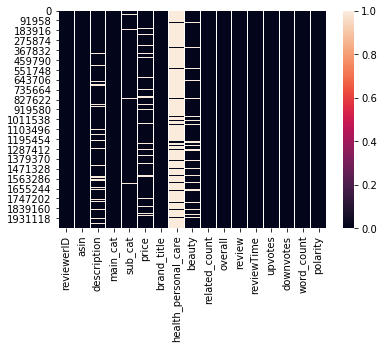

In [21]:
sns.heatmap(data.isnull())
plt.show()

In [22]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2023070 entries, 0 to 2023069
Data columns (total 17 columns):
reviewerID              2023070 non-null object
asin                    2023070 non-null object
description             1848819 non-null object
main_cat                2023070 non-null object
sub_cat                 1996852 non-null object
price                   1803170 non-null float64
brand_title             2023070 non-null object
health_personal_care    199260 non-null float64
beauty                  1773894 non-null float64
related_count           2023070 non-null float64
overall                 2023070 non-null int64
review                  2023067 non-null object
reviewTime              2023070 non-null object
upvotes                 2023070 non-null int64
downvotes               2023070 non-null int64
word_count              2023070 non-null int64
polarity                2023070 non-null float64
dtypes: float64(5), int64(4), object(8)
memory usage: 262.4+ MB


Missing values can lead to weak or biased analysis. 

It can be handled in 3 ways: 
1. Delete the rows with missing values using dropna - note that this can cause information loss
2. Impute the missing values using fillna
3. Predictive filling using the interpolate method

Approx 11% of rows have a missing Price. We will drop these rows. 

Approx 9% of rows have a missing Description. Since we are not sure how this column will be used, we will keep these rows for now.

In [23]:
data.dropna(subset=['price'],inplace=True)
data.reset_index(drop=True, inplace=True)
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1803170 entries, 0 to 1803169
Data columns (total 17 columns):
reviewerID              1803170 non-null object
asin                    1803170 non-null object
description             1660798 non-null object
main_cat                1803170 non-null object
sub_cat                 1782311 non-null object
price                   1803170 non-null float64
brand_title             1803170 non-null object
health_personal_care    180512 non-null float64
beauty                  1581910 non-null float64
related_count           1803170 non-null float64
overall                 1803170 non-null int64
review                  1803168 non-null object
reviewTime              1803170 non-null object
upvotes                 1803170 non-null int64
downvotes               1803170 non-null int64
word_count              1803170 non-null int64
polarity                1803170 non-null float64
dtypes: float64(5), int64(4), object(8)
memory usage: 233.9+ MB


Let’s apply the describe() method over this dataset to see the description of mean, standard deviation, quartiles and maximum & minimum values.

In [24]:
pd.set_option('float_format', '{:f}'.format)
data.describe()

,price,health_personal_care,beauty,related_count,overall,upvotes,downvotes,word_count,polarity
count,1803170.000000,180512.000000,1581910.000000,1803170.000000,1803170.000000,1803170.000000,1803170.000000,1803170.000000,1803170.000000
mean,22.362908,83582.684403,61680.745049,128.996248,4.152042,1.443627,1.862644,66.608815,0.275775
std,27.307156,134396.267623,109639.280355,306.013899,1.305894,9.249074,10.269228,67.531936,0.241965
min,0.010000,123.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,-1.000000
25%,8.000000,8364.000000,3040.000000,0.000000,4.000000,0.000000,0.000000,29.000000,0.128903
50%,14.950000,29084.000000,16673.000000,20.000000,5.000000,0.000000,0.000000,45.000000,0.275000
75%,26.990000,102122.000000,74094.000000,132.000000,5.000000,1.000000,2.000000,78.000000,0.431429
max,999.990000,1400818.000000,1233410.000000,3937.000000,5.000000,3562.000000,3643.000000,3951.000000,1.000000


Some products have been ranked under health_personal_care while others have been ranked under beauty. So the sales ranking is bucketed under either of the 2 categories. Which means, there would be many missing values in these 2 columns. To eliminate this issue, we could replace the NaN with -1 to indicate that the product is not ranked in this category.

In [25]:
data['health_personal_care'] = data['health_personal_care'].fillna(-1)
data['beauty'] = data['beauty'].fillna(-1)

"sub_cat" column also has some missing values. Let's investigate why.

In [26]:
data[data['sub_cat'].isnull()].head()

,reviewerID,asin,description,main_cat,sub_cat,price,brand_title,health_personal_care,beauty,related_count,overall,review,reviewTime,upvotes,downvotes,word_count,polarity
292,A1OVF6WMXX9CBS,9740200133,"Created especially for the Tom Ford store in Milan, this fashionable scent is the perfect blend of tradition and innovation. The aromatic chypre contains notes of vibrant citrus, verdant basil and mint that meld with radiant wood.",Fragrance]],NaN,24.990000,Tom Ford Tom Ford Private Blend Perfume 4ml Italian Cypress Bottle,-1.000000,78411.000000,28.000000,3,good try samples cant tell difference halston z14 good thing tried small bottle purchased larger bottle 210 tried sample thought faded masculine scent drydown sample starts sweet woody dries sweet,2014-02-11,0,0,60,0.278571
293,A3E60CSK5WW8BQ,9740200133,"Created especially for the Tom Ford store in Milan, this fashionable scent is the perfect blend of tradition and innovation. The aromatic chypre contains notes of vibrant citrus, verdant basil and mint that meld with radiant wood.",Fragrance]],NaN,24.990000,Tom Ford Tom Ford Private Blend Perfume 4ml Italian Cypress Bottle,-1.000000,78411.000000,28.000000,3,good good service fast delivery nice perfume thing bottle tiny one get idea overall quality perfume,2013-08-16,1,3,30,0.366667
532,A1O8JBGRANCVEO,9788071848,Jo Malone Iris & White Musk Cologne 3.4 Oz. Spray,Fragrance]],NaN,258.040000,Jo Malone Jo Malone Iris &amp; White Musk Cologne 3.4 Oz. Spray,-1.000000,621047.000000,1.000000,2,nothing new smells exactly like kiehls musk eau de toilette spray smell great jo malones costs 135 nordstom sure costs almost twice much kiehls 4250 17 oz save money go kiehls like fragrance,2012-12-14,4,5,59,0.377273
636,A3BZHI48MZWE7D,978807278X,"Donna Karan Iris For Her Eau De Parfume 4 Ml Spray\nThe Iris takes its name from the Greek word for rainbow, and this flower's scent is uplifting, fresh and inspiring. Blend with the other scents from Donna Karan's collection or wear alone and let the note take centre stage.",Fragrance]],NaN,17.000000,Donna Karan Iris Eau De Parfume 4 Ml Spray Mini,-1.000000,767410.000000,0.000000,3,nice iris scent decent iris fragrance good many bad ive used mostly layering perfumes,2013-10-28,0,0,27,0.294444
647,A1T6PQ4F5BMKLU,9788073328,Christian Dior Patchouli Imprial Cologne 8.5 Oz Spray,Fragrance]],NaN,545.990000,Dior Christian Dior Patchouli Imp&eacute;rial Cologne 8.5 Oz Spray,-1.000000,630748.000000,0.000000,5,elegant mystery implicit trust dior imperial patchouli inspires sandalwood patchouli ancient times bewitching classy perfect woman carries high powered professional duties client spellbound wearing little bit contract signing time negotiations,2012-03-03,0,1,49,0.338929


It looks like some of the items did not have a subcategory. The values in main category are Skin Care]] or Fragrance]]. The square brackets at the end of these strings will have to be removed and the missing value in "sub_cat" would have to be imputed.

In [27]:
data['main_cat'] = data['main_cat'].str.replace(']]','')

In [28]:
plot_size = plt.rcParams["figure.figsize"] 
print(plot_size[0]) 
print(plot_size[1])

plot_size[0] = 11
plot_size[1] = 8
plt.rcParams["figure.figsize"] = plot_size 

6.0
4.0


First let's create a pie plot to see the percentage of different overall values.

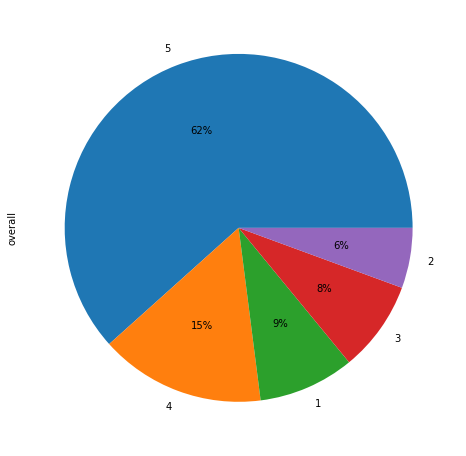

In [29]:
data.overall.value_counts().plot(kind='pie', autopct='%1.0f%%')

Most of the reviews have overall rating of 5 which means positive reviews. Let's next plot the polarity to see if the overall stats match with polarity.

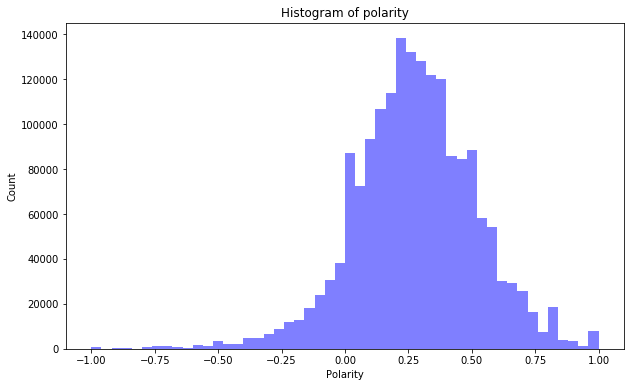

In [30]:
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(data.polarity, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Histogram of polarity')
plt.show();

Most of the polarity scores are above 0, which means most reviews have positive sentiments in the data. This observation matches what we saw with the pie chart for overall scores.

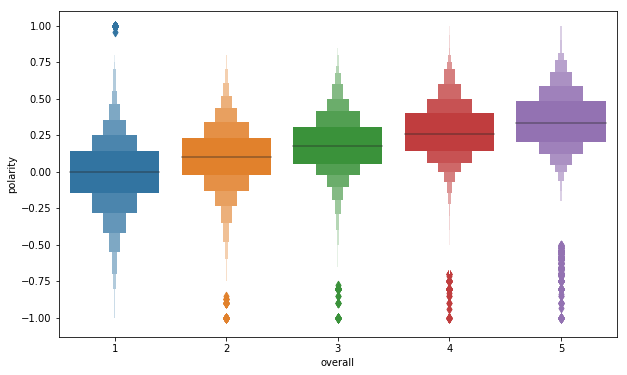

In [31]:
plt.figure(figsize=(10,6))
sns.boxenplot(x='overall', y='polarity', data=data)
plt.show();

The above plot shows polarity grouped by overall score. For most part, it looks good. There are some reviews that have overall score of 4 or 5, yet the polarity is below 0 indicating negative sentiments. Let's investigate this deeper to compare polarity and overall rating.

First, let's look for reviews with lowest polarity.

In [32]:
data[data.polarity == -1].review.head()

3883     chips chips hours wear terrible product would purchase eye liner                                                                                                                                                                                                                                                                                             
4370     smells awfuldoes work started using morning cant comment effectiveness yet however smell alone disgusting smell like railroad tie thought would rinse hasnt im sitting work hoping one approaches coworkers going wonder whos paving driveway im going stick week handle smell dont feel relief even though claim box says get relief even one treatment come
7278     moisturizer body got tip coworker whos daughter terrible acnei use body lotion also face oily residue                                                                                                                                                                            

The above output shows that the polarity matches the text review. Let's check for reviews with highest polarity.

In [33]:
data[data.polarity == 1].review.head()

31     excellent delivered time excellent product                                                                            
51     five stars best soap ever                                                                                             
60     enhancer products market give results truly expect one regret decision try product best time                          
83     excellent product services keeps scalp feeling refreshed without greasy feeling recommend anyone flaky itchiness scalp
366    like excellent product using month twice week like excellent product using month twice week                           
Name: review, dtype: object

Next, let's check for reviews where polarity is lowest but overall score is highest, and vice-versa. This will indicate discrepancies between polarity and overall.

In [34]:
data[(data.polarity == -1) & (data.overall == 5)].review.head()

7278     moisturizer body got tip coworker whos daughter terrible acnei use body lotion also face oily residue                                        
16108    soothing purchased item neighbor undergoing surgery chemofor cancer helped get worst parts                                                   
38424    tastes horrible ive biting nails 20 years never bird crapped mouth id imagine would taste                                                    
38429    works stays 45 days definitely horrible taste downfall accidentally get taste really awful however daughter bite nails wears likes wear shiny
38957    tastes like stuff tastes horrible way kid suck hisher thumb stuff took taste couldnt get mouth hours yuck                                    
Name: review, dtype: object

In [35]:
data[(data.polarity == 1) & (data.overall == 1)].review.head()

1132      prices awesome fragrance 33 bottle 95 jimmy choo store eau de parfum spray 33fl dont understand price increase seller                              
27117     shown received squeeze tube expecting spray cotz excellent product already squeeze tube                                                            
82716     smell smell revolting may excellent choice antibacterial soap would wear gas mask every time washed hands                                          
116139    yuck doesnt smell anything like creme brleacutee dissapointed purchased laura mercier creme brleacutee smelled delicious smells like paste soap uck
126279    streaking gelee deliver awesome results gotten sunless loreal lotion rusty spots streaking wont buy                                                
Name: review, dtype: object

So there are quite a few reviews where the sentiment analysis is inconsistent with the overall rating.

Text(0.5, 1.0, 'Top 10 most common products')

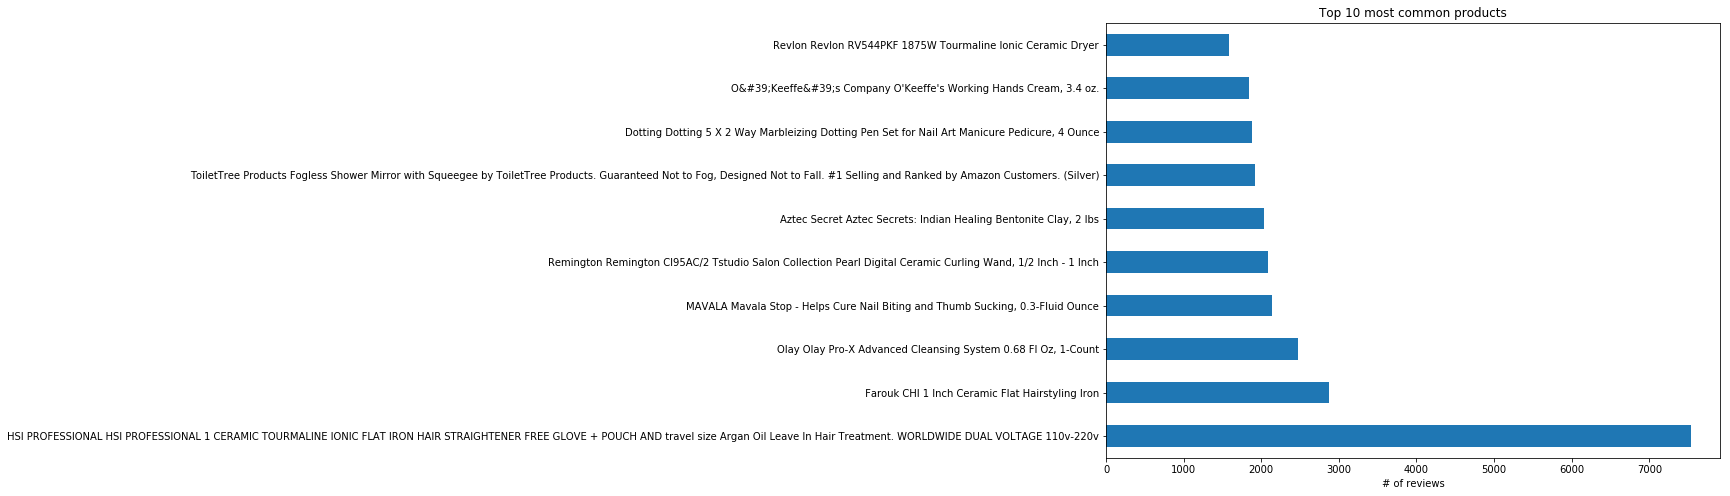

In [36]:
# ten most reviewed products
data.brand_title.value_counts()[:10].plot(kind='barh')
plt.xlabel('# of reviews')
plt.title('Top 10 most common products')

Text(0.5, 1.0, 'Top 10 reviewers')

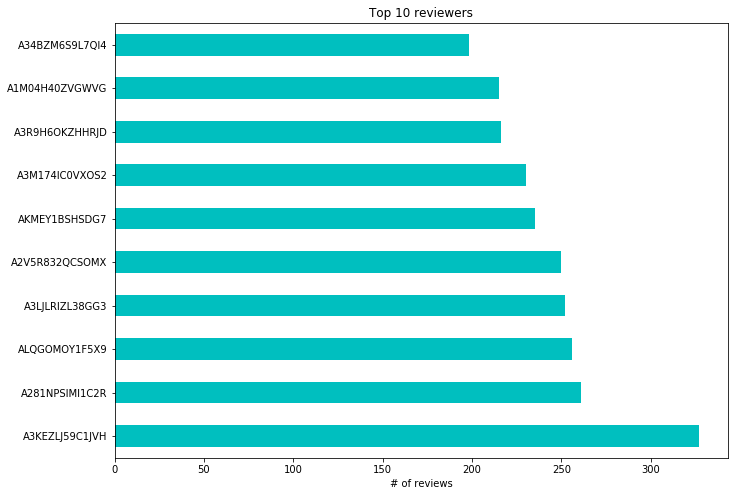

In [37]:
# top ten reviewers
data.reviewerID.value_counts()[:10].plot(kind='barh',color='c')
plt.xlabel('# of reviews')
plt.title('Top 10 reviewers')

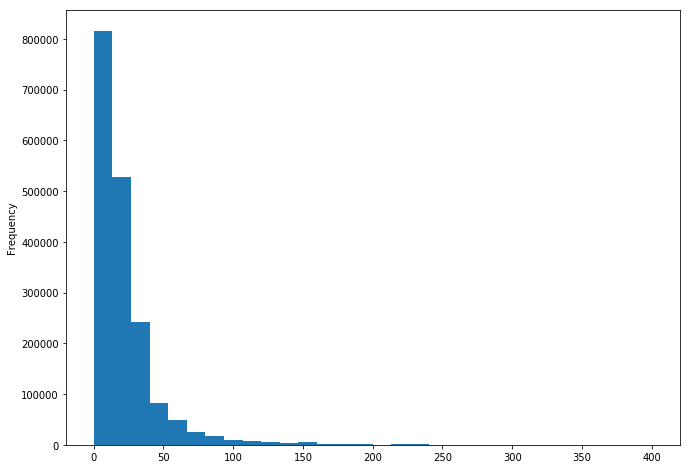

In [38]:
# plot the price
data.price.plot.hist(bins=30,range=(0,400))

In [39]:
# Mean rating for each Product

product_rating = data.groupby('asin')['overall'].mean()
product_rating.head()

asin
0762451459   5.000000
1304139220   5.000000
1304174905   5.000000
1304196135   5.000000
1304351475   3.562500
Name: overall, dtype: float64

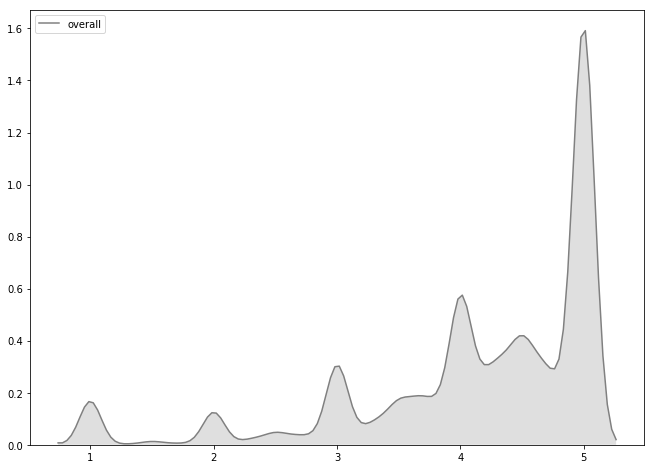

In [40]:
# Mean rating KDE distribution

ax = sns.kdeplot(product_rating, shade=True, color='grey')
plt.show()

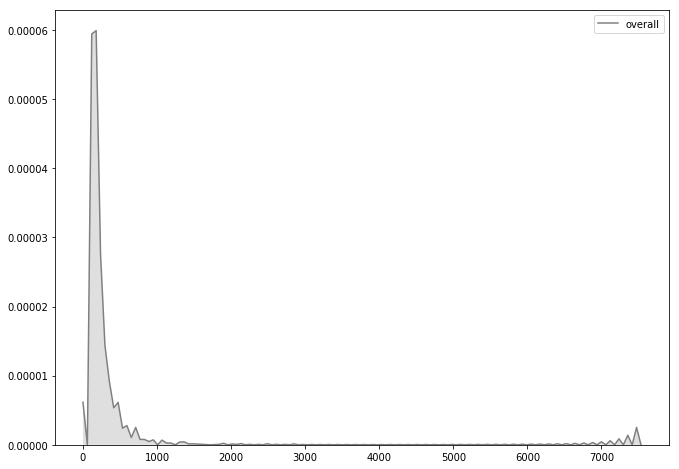

In [41]:
# Count of the number of ratings per Product

product_rating_count = data.groupby('asin')['overall'].count()

# Number of ratings per product KDE distribution

ax = sns.kdeplot(product_rating_count, shade=True, color='grey')
plt.show()

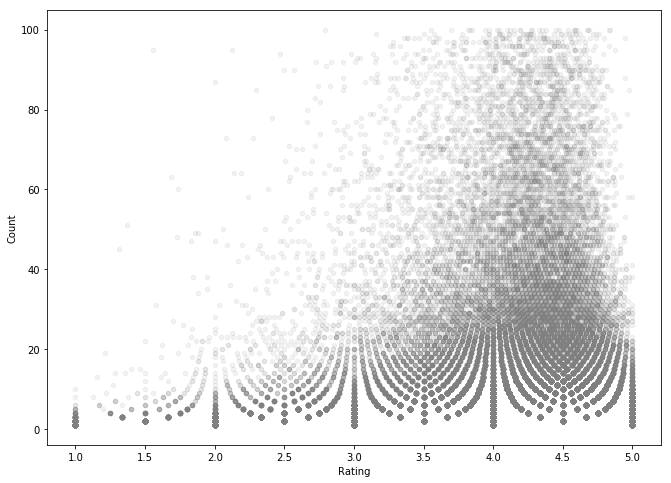

In [42]:
# Less than 100 ratings
unique_products_list = data.asin.unique()
data_model = pd.DataFrame({'Rating': product_rating[unique_products_list],\
                           'Count': product_rating_count[unique_products_list]})
ax = data_model[data_model.Count < 101].plot(kind='scatter', x='Rating', y='Count', color='grey', alpha=0.1)
plt.show()

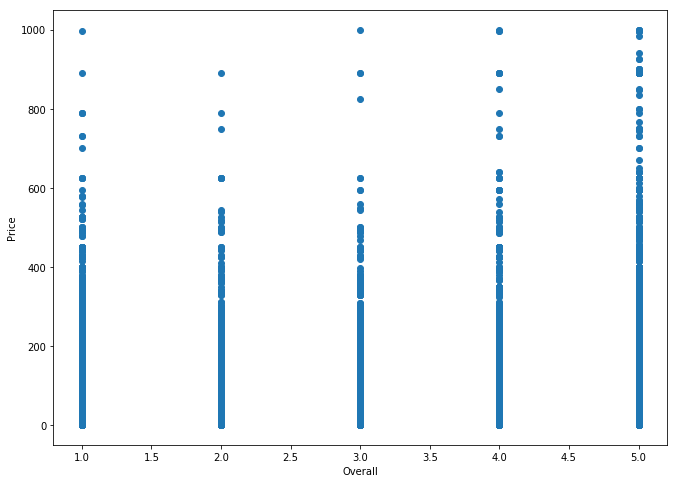

In [45]:
plt.scatter(data['overall'],data['price'])
plt.xlabel('Overall')
plt.ylabel('Price')
plt.show()

Correlation is a statistical metric that measures the relationship or dependence between two variables. in other words, how does a change in one variable affect the other?

The correlation can be calculated using the .corr() function. We then plot it on a heatmap to visualize the results.

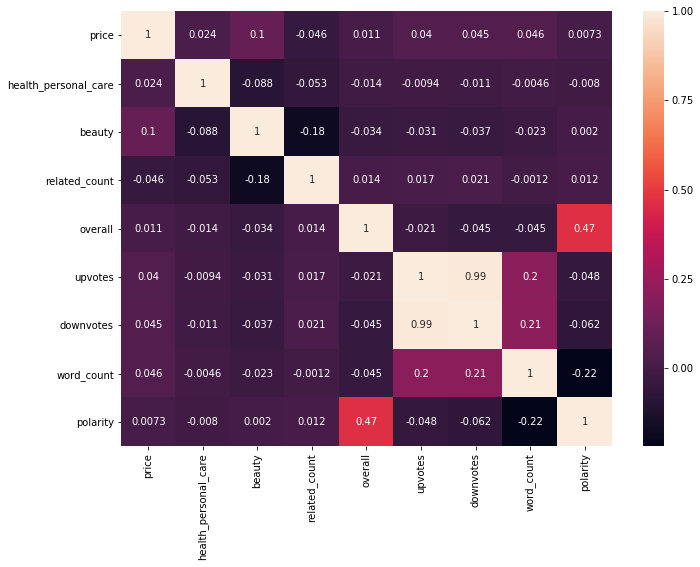

In [46]:
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

Price and Polarity have a strong positive correlation. Overall and Polarity also have a positive correlation, although not too strong, which is odd. 

In [ ]:
sns.regplot(x='polarity',y='price',data=data)

In [ ]:
sns.regplot(x='main_cat',y='overall',data=data)

## 4. Conclusion